In [ ]:
# Use the entire width of the screen if needed
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [64]:
import warnings
warnings.filterwarnings('ignore')



# Reset the kernel if needed

%reset -f

# import the relevant libraries etc.
# set up the environment

from qiskit import *
import numpy as np


%matplotlib inline



# Define the problem (the tridiagonal matrix that we are interested in solving)

a = 2
b = 1

# Problem size
n_w = 4
N_w = 2**n_w

# make the tridiagonal matrix in classical form
classical_matrix = np.zeros((N_w,N_w))


for _i in range(N_w):
    for _j in range(N_w):
        if _i==_j:
            classical_matrix[_i,_j]=a
        if abs(_i-_j)==1:
            classical_matrix[_i,_j]=b

print(np.around(classical_matrix,5))

eigenvalues = np.linalg.eigvals(classical_matrix)

print('maximum: {}\nminimum: {}\nkappa: {}'.format(np.max(eigenvalues),np.min(eigenvalues),np.abs(np.max(eigenvalues)/np.min(eigenvalues))))

# Define the eigenvalue register
n_l = 4

# Define the Trotterization
m = 10
# The order of the Trotter formula that we are using (shoot for the moon)

# Define the time; this depends on the spectrum and size of the clock register
#t = 0.95*np.pi/(max(abs(eigenvalues)))
t = 1

# Define the registers for the problem
work_register = QuantumRegister(n_w,name='work')
clock_register = QuantumRegister(n_l,name='clock')
ancilla = AncillaRegister(1,name='controlled_rotation')



[[2. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 2. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 2. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 2. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 2. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 2. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 2. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 2. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 2. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2.]]
maximum: 3.965946199367801
minimum: 0.03405380063219667
kappa: 116.4611915774869


In [65]:
# Make a functions that return the different pieces of the hamiltonian (exponentiated) with the required amount
# of Hamiltonian simulation (requested t)

def H1(a,b,t,work_register,n_w):
    H1_circuit = QuantumCircuit(work_register,name='H1')
    H1_circuit.x(n_w-1)
    H1_circuit.p(a*t,n_w-1)
    H1_circuit.x(n_w-1)
    H1_circuit.p(a*t,n_w-1)
    H1_circuit.draw(output='mpl')
    return H1_circuit


def H2(a,b,t,work_register,n_w):
    H2_circuit = QuantumCircuit(work_register,name='H2')
    H2_circuit.rx(-2*b*t,n_w-1)
    H2_circuit.draw(output='mpl')
    return H2_circuit


def H3(a,b,t,work_register,n_w):
    H3_circuit = QuantumCircuit(work_register,name='H3')
    
    # H3 is made up of a bunch of C circuits
    C_circuits = []
    
    # We need to make a multi-controlled RX gate for each C
    from qiskit.circuit.library.standard_gates import RXGate
    from qiskit.circuit.library.standard_gates import RYGate
    
    for _C in range(1,n_w):
        _C_circuit = QuantumCircuit(work_register[-1-_C:],name='C{}'.format(_C))
        _C_circuit.cnot(1,0,ctrl_state=1)
        for _target in range(2,_C+1):
            _C_circuit.cnot(1,_target,ctrl_state=0)
        # Create the multi controlled Rx gate
        #if (_C-2)>=1:
        #    _rx_gate = RXGate(-2*b*dt).control(_C-2)
        #    _C_circuit.append(_rx_gate,[])
        _rx_gate = RXGate(-2*b*t).control(_C)
        _controls_targets = [_x for _x in range(_C+1) if _x != 1]
        _controls_targets.append(1)
        _C_circuit.append(_rx_gate,_controls_targets)
    

        for _target in reversed(range(2,_C+1)):
            _C_circuit.cnot(1,_target,ctrl_state=0)
        _C_circuit.cnot(1,0,ctrl_state=1)
        C_circuits.append(_C_circuit)
        
    # Append the C circuits to the overall H3 circuit
    #H3_circuit.barrier()
    for _C in C_circuits:
        H3_circuit = H3_circuit + _C
        #H3_circuit.barrier()
        
    return H3_circuit



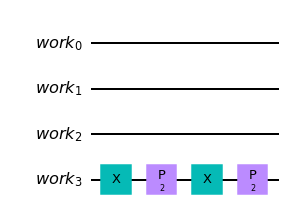

In [66]:
_H1 = H1(a,b,1,work_register,n_w)
_H1.draw(output='mpl')

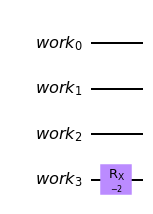

In [67]:
_H2 = H2(a,b,1,work_register,n_w)
_H2.draw(output='mpl')

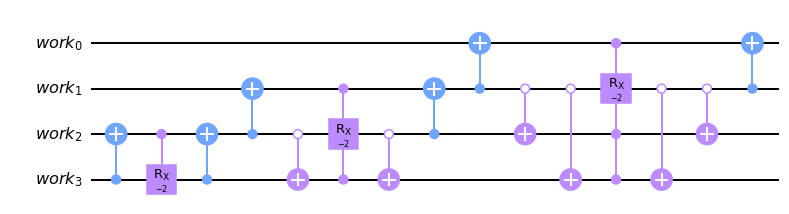

In [68]:
_H3 = H3(a,b,1,work_register,n_w)
_H3.draw(output='mpl')

In [69]:
# Now we want to combine all the pieces together to make function that will return powers of U
# Basically we are going to repeat the circuit to apply the powers (H1 commutes so no need for that part)




# # Note: i here is the power of 2 we are raising U to
# def U_pow(a,b,t,work_register,n_w,m,power,return_circuit=False):
#     U_pow_circuit = QuantumCircuit(work_register,name='U^{}'.format(2**power))
#     for _i in range((2**power)*m):
#         U_pow_circuit=U_pow_circuit+H1(a,b,t/m,work_register,n_w)
#         U_pow_circuit=U_pow_circuit+H2(a,b,t/m,work_register,n_w)
#         U_pow_circuit=U_pow_circuit+H3(a,b,t/m,work_register,n_w)
#     if not return_circuit:
#         return U_pow_circuit.to_gate(label='U^{}'.format(int(np.sign(t))*2**power))
#     else:
#         return U_pow_circuit


def U_pow(a,b,t,work_register,n_w,m,power,return_circuit=False):
    U_pow_circuit = QuantumCircuit(work_register,name='U^{}'.format(2**power))
    U_pow_circuit = U_pow_circuit+H1(a,b,t*2**power,work_register,n_w)
    for _i in range((2**power)*m):
        #U_pow_circuit.barrier()
        U_pow_circuit=U_pow_circuit+H2(a,b,t/2/m,work_register,n_w)
        #U_pow_circuit.barrier()
        U_pow_circuit=U_pow_circuit+H3(a,b,t/m  ,work_register,n_w)
        #U_pow_circuit.barrier()
        U_pow_circuit=U_pow_circuit+H2(a,b,t/2/m,work_register,n_w)
        #U_pow_circuit.barrier()
    if not return_circuit:
        return U_pow_circuit.to_gate(label='U^{}'.format(int(np.sign(t))*2**power))
    else:
        return U_pow_circuit

In [83]:
power = 0
t = 0.1
m = 100

# Now we want to start testing out the Hamiltonian Simulation portion, whether we are getting the correct
# exponentiation of the matrix that we expect
U_exp = U_pow(a,b,t,work_register,n_w,m,power,return_circuit=True)

#U_exp.draw(output='mpl')


In [84]:

simulator = Aer.aer.get_backend("unitary_simulator")
unitary = execute(U_exp.reverse_bits(),simulator).result().get_unitary()
trotter_solution = unitary.data

In [85]:
from scipy.linalg import expm
i = 0+1j
exact_solution = expm(classical_matrix*t*i*2**power)

In [86]:
np.linalg.norm(trotter_solution-exact_solution,2)

9.366286005429899e-05

In [74]:
print(np.around(exact_solution,3))

[[ 0.975+0.198j -0.02 +0.098j -0.005-0.001j  0.   -0.j     0.   +0.j
  -0.   +0.j    -0.   -0.j     0.   -0.j     0.   +0.j    -0.   +0.j
  -0.   -0.j     0.   -0.j     0.   +0.j    -0.   +0.j    -0.   -0.j
   0.   -0.j   ]
 [-0.02 +0.098j  0.97 +0.197j -0.02 +0.098j -0.005-0.001j  0.   -0.j
   0.   +0.j    -0.   +0.j    -0.   -0.j     0.   -0.j     0.   +0.j
  -0.   +0.j    -0.   -0.j     0.   -0.j     0.   +0.j    -0.   +0.j
  -0.   -0.j   ]
 [-0.005-0.001j -0.02 +0.098j  0.97 +0.197j -0.02 +0.098j -0.005-0.001j
   0.   -0.j     0.   +0.j    -0.   +0.j    -0.   -0.j     0.   -0.j
   0.   +0.j    -0.   +0.j    -0.   -0.j     0.   -0.j     0.   +0.j
  -0.   +0.j   ]
 [ 0.   -0.j    -0.005-0.001j -0.02 +0.098j  0.97 +0.197j -0.02 +0.098j
  -0.005-0.001j  0.   -0.j     0.   +0.j    -0.   +0.j    -0.   -0.j
   0.   -0.j     0.   +0.j    -0.   +0.j    -0.   -0.j     0.   -0.j
   0.   +0.j   ]
 [ 0.   +0.j     0.   -0.j    -0.005-0.001j -0.02 +0.098j  0.97 +0.197j
  -0.02 +0.098j -0.005-0.0

In [75]:
print(np.around(trotter_solution,3))

[[ 0.975+0.198j -0.02 +0.098j -0.004-0.001j  0.   -0.j     0.   +0.j
  -0.   +0.j    -0.   -0.j     0.   -0.j     0.   +0.j    -0.   +0.j
  -0.   -0.j     0.   -0.j     0.   -0.j    -0.   -0.j    -0.   +0.j
   0.   +0.j   ]
 [-0.02 +0.098j  0.97 +0.197j -0.02 +0.098j -0.005-0.001j  0.   -0.j
   0.   +0.j    -0.   +0.j    -0.   -0.j     0.   -0.j     0.   +0.j
  -0.   +0.j    -0.   -0.j    -0.   -0.j    -0.   +0.j     0.   +0.j
  -0.   +0.j   ]
 [-0.005-0.001j -0.02 +0.098j  0.97 +0.197j -0.02 +0.098j -0.004-0.001j
   0.   -0.j     0.   +0.j    -0.   +0.j    -0.   -0.j     0.   -0.j
   0.   +0.j    -0.   +0.j    -0.   +0.j     0.   +0.j    -0.   +0.j
  -0.   -0.j   ]
 [ 0.   -0.j    -0.004-0.001j -0.02 +0.098j  0.97 +0.197j -0.02 +0.098j
  -0.005-0.001j  0.   -0.j     0.   +0.j    -0.   +0.j    -0.   -0.j
   0.   -0.j     0.   +0.j     0.   +0.j    -0.   +0.j    -0.   -0.j
   0.   -0.j   ]
 [ 0.   +0.j     0.   -0.j    -0.005-0.001j -0.02 +0.098j  0.97 +0.197j
  -0.02 +0.098j -0.004-0.0

In [76]:
from qiskit.quantum_info import Operator


In [77]:
np.around(Operator(U_exp.reverse_bits()).data,3)

array([[ 0.975+0.198j, -0.02 +0.098j, -0.004-0.001j,  0.   -0.j   ,
         0.   +0.j   , -0.   +0.j   , -0.   -0.j   ,  0.   -0.j   ,
         0.   +0.j   , -0.   +0.j   , -0.   -0.j   ,  0.   -0.j   ,
         0.   +0.j   ,  0.   +0.j   ,  0.   -0.j   , -0.   +0.j   ],
       [-0.02 +0.098j,  0.97 +0.197j, -0.02 +0.098j, -0.005-0.001j,
         0.   -0.j   ,  0.   +0.j   , -0.   +0.j   , -0.   -0.j   ,
         0.   -0.j   ,  0.   +0.j   , -0.   +0.j   , -0.   -0.j   ,
         0.   -0.j   , -0.   -0.j   , -0.   +0.j   , -0.   +0.j   ],
       [-0.005-0.001j, -0.02 +0.098j,  0.97 +0.197j, -0.02 +0.098j,
        -0.004-0.001j,  0.   -0.j   ,  0.   +0.j   , -0.   +0.j   ,
        -0.   -0.j   ,  0.   -0.j   ,  0.   +0.j   , -0.   +0.j   ,
        -0.   -0.j   ,  0.   +0.j   , -0.   -0.j   , -0.   -0.j   ],
       [ 0.   -0.j   , -0.004-0.001j, -0.02 +0.098j,  0.97 +0.197j,
        -0.02 +0.098j, -0.005-0.001j,  0.   -0.j   ,  0.   +0.j   ,
        -0.   +0.j   , -0.   -0.j   ,  0.   -

In [78]:
classical_matrix

array([[2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,